# Graphs with NetworkX

https://cnvrg.io/graph-neural-networks/

Let’s take a minute and look at how one can create graphs using NetworkX. NetworkX is a Python package that can be used for creating graphs. Here is how you can use the package to create an empty graph with no nodes. 



In [3]:
import networkx as nx
G = nx.Graph()

You can then add some nodes to the graph using the `add_nodes` function. 

In [4]:
G.add_nodes_from([2,3])

 add some edges to the graph using the `add_edges_from` function. 

In [6]:
edges = [(2,1),(2,2),(3,2),(4,3),(6,4),(7,5),(14,5)]
G.add_edges_from(edges)

The graph can be visualized using Matplotlib. That is done by calling the `draw` function and using Matpotlib to show the graph. 

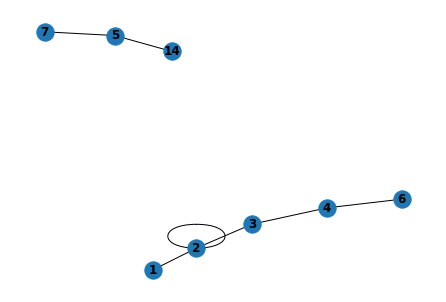

In [12]:
nx.draw(G, with_labels=True, font_weight='bold')
import matplotlib.pyplot as plt
plt.show()

The original GNN proposal had a couple of limitations: 

Updating of the hidden states of nodes was inefficient for a fixed point 
The GNNs used the same parameters in each iteration while other neural networks use different parameters in each layer
Modeling of informative features obtained from the edges was difficult 

Types of Graph Neural Networks
1.Graph Convolutional Networks (GCNs)
    Graph Convolutional Networks (GCNs) utilize the same convolution operation as in normal Convolutional Neural Networks. GCNs learn features through the inspection of neighboring nodes. They are usually made up of a Graph convolution, a linear layer, and non-linear activation. GNNs work by aggregating vectors in the neighborhood, passing the result to a dense neural net layer, and finally applying non-linearity.  GNNs differ from CNNs in that they are built to work with non-Euclidian structured data. There are two major types of GCNs namely:
    1. Spatial Convolutional Networks. In these networks, the features of neighboring nodes are combined into a central node. The features are summed similar to the normal convolution operation. 
    2. Spectral Convolutional Network: In Spectral networks, the convolution operation is defined in the Fourier domain by computing the eigendecomposition of the graph Laplacian.

Recurrent Graph Neural Networks:
    Graph recurrent neural networks (GRNNs) utilize multi-relational graphs and use graph-based regularizers to boost smoothness and mitigate over-parametrization. Since the exact size of the neighborhood is not always known a Recurrent GNN layer is used to make the network more flexible. GRNN can learn the best diffusion pattern that fits the data. It is also able to handle situations where a node is involved in multiple relations. The network is also computationally inexpensive because the number of operations is scaled linearly with regard to the number of graph edges. 

Example: Graph Neural Networks with PyTorch

In [7]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


The example shows how to build a GNN for a semi-supervised node classification model on the Cora dataset. The next step is to define the  Graph Convolutional Network that will compute node representations using neighborhood information. This is done using `dgl.nn.GraphConv`.

The next move is to train the neural network. The training is done similar to how you would have done training in PyTorch or TensorFlow. 

In [21]:
from dgl.nn import GraphConv
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In [22]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
train(g, model)

In epoch 0, loss: 1.947, val acc: 0.112 (best 0.112), test acc: 0.123 (best 0.123)
In epoch 5, loss: 1.893, val acc: 0.206 (best 0.358), test acc: 0.226 (best 0.378)
In epoch 10, loss: 1.810, val acc: 0.246 (best 0.358), test acc: 0.278 (best 0.378)
In epoch 15, loss: 1.704, val acc: 0.392 (best 0.392), test acc: 0.417 (best 0.417)
In epoch 20, loss: 1.578, val acc: 0.462 (best 0.462), test acc: 0.502 (best 0.502)
In epoch 25, loss: 1.431, val acc: 0.566 (best 0.566), test acc: 0.608 (best 0.608)
In epoch 30, loss: 1.268, val acc: 0.640 (best 0.640), test acc: 0.660 (best 0.660)
In epoch 35, loss: 1.095, val acc: 0.712 (best 0.712), test acc: 0.704 (best 0.704)
In epoch 40, loss: 0.923, val acc: 0.740 (best 0.740), test acc: 0.724 (best 0.724)
In epoch 45, loss: 0.761, val acc: 0.752 (best 0.752), test acc: 0.743 (best 0.743)
In epoch 50, loss: 0.617, val acc: 0.752 (best 0.756), test acc: 0.754 (best 0.750)
In epoch 55, loss: 0.496, val acc: 0.756 (best 0.756), test acc: 0.768 (best 0

# Training a GNN for graph classification



In [7]:
import tensorflow.keras as ks
from kgcnn.layers.gather import GatherNodes
from kgcnn.layers.keras import Dense, Concatenate  # ragged support
from kgcnn.layers.pool.pooling import PoolingLocalMessages, PoolingNodes

n = ks.layers.Input(shape=(None, 3), name='node_input', dtype="float32", ragged=True)
ei = ks.layers.Input(shape=(None, 2), name='edge_index_input', dtype="int64", ragged=True)

n_in_out = GatherNodes()([n, ei])
node_messages = Dense(10, activation='relu')(n_in_out)
node_updates = PoolingLocalMessages()([n, node_messages, ei])
n_node_updates = Concatenate(axis=-1)([n, node_updates])
n_embedd = Dense(1)(n_node_updates)
g_embedd = PoolingNodes()(n_embedd)

message_passing = ks.models.Model(inputs=[n, ei], outputs=g_embedd)

2021-10-12 17:02:35.064999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-12 17:02:35.065062: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-12 17:02:35.065111: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sraj-OptiPlex-5050): /proc/driver/nvidia/version does not exist
2021-10-12 17:02:35.065620: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from kgcnn.layers.conv.message import MessagePassingBase
from kgcnn.layers.keras import Dense, Add

def MyMessageNN(MessagePassingBase):

    def __init__(self, units, **kwargs):
        super(MyMessageNN, self).__init__(**kwargs)
        self.dense = Dense(units)
        self.add = Add(axis=-1)

    def message_function(self, inputs, **kwargs):
        n_in, n_out, edges = inputs
        return self.dense(n_out)

    def update_nodes(self, inputs, **kwargs):
        nodes, nodes_update = inputs
        return self.add([nodes, nodes_update])

